# Intro to Regularization With Ridge And Lasso Regression
## Explaining the full intuition behind Ridge Regression using Sklearn
<img src='images/ridge.jpg'></img>
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/@rachel-claire?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Rachel Claire</a>
        on 
        <a href='https://www.pexels.com/photo/rough-mountain-near-grassy-terrain-under-sky-4992636/?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pexels</a>
    </strong>
</figcaption>

### Setup

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = 100

### Problems of Linear Regression

Linear Regression a.k.a. Ordinary Least Squares is one of the easiest and most widely used ML algorithms. But it suffers from a fatal flaw - it is super easy for the algorithm to overfit the training data. 

For the simplest case - 2D data, everything just clicks visually: Line of best fit is the line that minimizes the sum of squared residuals (SSR):

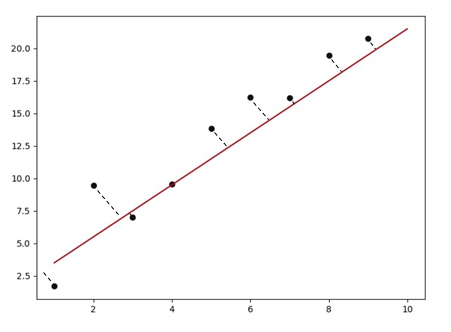
<figcaption style="text-align: center;">
    <strong>
        Image by author
    </strong>
</figcaption>

The formula is not that hard too:

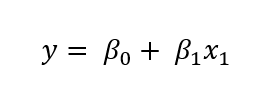

But as the number of predictor variables (or dimensions) increase, the coefficients *β_i* also tend to get very large. With large coefficients, it is easy to predict nearly everything - you just take the relevant combination of individual slopes (*β*s) and you get the answer. That's why, it is common for linear regression models to overfit the training data. 

Another problem of LR is that it does not care about the weights of the features. As long as there is a linear relationship between them, you get a model with OLS minimized. But in reality, you do want your model to care about the weight of each feature. For example, if you are trying to predict the number of new-born babies in a town, an obvious factor would be the number of fertile women. However, the number of storks in that particular town would be completely irrelevant. But if these figures coincidentally represent a linear relationship and you use both of them for linear regression, you get a crappy model but still with OLS minimized.

And in practice, this is a real and common problem: today's datasets contain many, *many* features both useful and useless to the target you are trying to predict.

### Bias and variance trade-off

To understand how Ridge Regression solves the above two problems, we have to understand two other important topics: **bias** and **variance**.

Variance is always associated with a model failing to perform well on new (test) set. High variance leads to overfitting which makes sense because overfit models generate vastly *different*, inconsistent results for different datasets. 

In contrast, bias is the inability of the model to generalize on the training data. A model with too much bias fails to generalize both on training and test sets.

Ideally, the perfect model would have low bias and low variance but that is easier said than done. Because, bias and variance are in a trade-off relationship over model complexity. 

<img src='images/1.png'></img>

> Model complexity is determined by the number of dimensions input to the model, i. e. the number of features.

As linear regression has very low bias (does not care about predictors), it fits training data well. But the fit is too specific resulting in a model with very high variance putting Linear Regression at the far right of the Model Complexity Plot:

<img src='images/2.png'></img>

### Regularization With Ridge

Both problems related to bias and overfitting can be elegantly solved using Ridge and Lasso Regression. The equation for the line of best fit is still the same for the new two regressions:

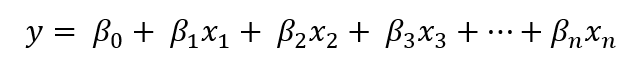

What is changed is the cost function. Both Ridge and Lasso Regression introduce a new hyperparameter to the OLS - $\lambda$. Let's first look at the cost function of Ridge:

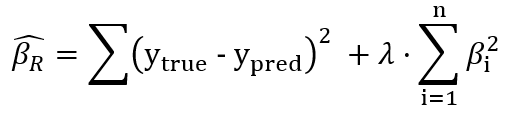

Apart from OLS (the first part), ridge regression squares every individual slopes of the feature variables and scales them by some number $\lambda$. This is called Ridge Regression penalty. What this penalty essentially does is to shrink all coefficients (slopes). This shrinkage has double effect: 
 - We avoid overfitting with lower coefficients. As *lambda* is just some constant, it has the same scaling effect on all coefficients. For example, by choosing a low value for *lambda* like 0.1, we get to scale all coefficients both large and small.
 - This scaling also introduces some bias to the completely unbiased LR. Think about it this way - if you square a large number, you get an even larger number. Choosing a low value like 0.01 you get to shrink the number a lot. But if you square small numbers such as numbers lower than 1, instead of getting a larger number, you get even smaller number. And multiplying it by 0.01, you manage to make it even smaller. This way, ridge regression gets to make important features more pronounced and shrink unimportant ones close to 0 which leads to a more simplified model.

You might be saying that the added sum of scaled, squared slopes will be bigger which does not fit the training data as well as the plain-old OLS. It is true but starting with a slightly worse fit, Ridge and Lasso provides better and more consistent predictions in the long run. By introducing a small amount of bias, we get a significant drop in variance.

Let's see Ridge in action using Scikit-learn. `Ridge` follows the same API like any other model offered by `sklearn`. We will work on the [Ames Housing Dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) from Kaggle. Using a subset of features, we will predict house prices using Ridge in this section and Lasso in the next one. To make things short, I am loading an already-processed dataset (feature selected, scaled and imputed):

In [77]:
from sklearn.model_selection import train_test_split

# Only choose numerical features
houses = pd.read_csv('data/train.csv')
houses.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,TotalSF,SalePrice
0,60,8450,7,5,2003,2003,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,2,2008,2566,208500
1,20,9600,6,8,1976,1976,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,5,2007,2524,181500
2,60,11250,7,5,2001,2002,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,9,2008,2706,223500
3,70,9550,7,5,1915,1970,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,2,2006,2473,140000
4,60,14260,8,5,2000,2000,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,12,2008,3343,250000


In [78]:
X = houses.drop('SalePrice', axis=1)
y = houses.SalePrice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1121218)

For simplicity, I only chose numeric features. First, we will fit a `LinearRegression` model and compare its performance to `Ridge` using MAE (Mean Absolute Error). Before we do this, there are a few preprocessing required like feature scaling the variables and filling in missing values. So, I will create a simple `Pipeline` instances to deal with them:

> If you want to know more about `pipelines` using `sklearn` check out this [article](https://towardsdatascience.com/how-to-use-sklearn-pipelines-for-ridiculously-neat-code-a61ab66ca90d) or [notebook](https://www.kaggle.com/bextuychiev/lasso-regression-with-pipelines-tutorial) on Kaggle.

Now, let's first fit a Linear Regressor:

In [79]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error

# Initilize, fit, predict
lin_reg = LinearRegression()
_ = lin_reg.fit(X_train, y_train)
preds = lin_reg.predict(X_test)
print("Training score:", lin_reg.score(X_train, y_train))
print("Testing score:", lin_reg.score(X_test, y_test))
print("MAE of Linear Regression:", mean_absolute_error(y_test, preds), '\n')

Training score: 0.8407611240459149
Testing score: 0.7150883693754784
MAE of Linear Regression: 22010.868252393684 



As you can see, testing score is significantly lower than training's which suggests overfitting. Now, let's try Ridge:

In [80]:
ridge = Ridge(alpha=0.1)
_ = ridge.fit(X_train, y_train)
preds = ridge.predict(X_test)
print("Training score:", ridge.score(X_train, y_train))
print("Testing score:", ridge.score(X_test, y_test))
print("MAE of Ridge Regression:", mean_absolute_error(y_test, preds), '\n')

Training score: 0.8407611145827576
Testing score: 0.7150830476206471
MAE of Ridge Regression: 22010.48344888848 



We get almost identical results for Ridge because we chose too small value for `alpha`. If you go back to the cost function of Ridge, you can see that if we set *lambda* to 0, we get plain-old OLS back:

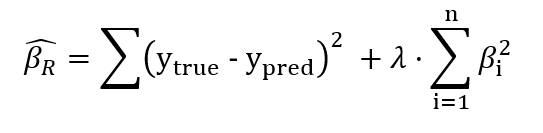

> Note that in `sklearn` API, the hyperparater `lambda` is given as `alpha`. Don't get confused.

Now, instead of blindly trying out a bunch of values for `alpha`, we can use cross-validation using `RidgeCV`. Instead of taking a single value for `alpha`, RidgeCV takes a list of possible alphas and tries them out using cross-validation, just like GridSearch:

In [81]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=np.arange(1, 100, 5), scoring='r2', cv=10)
_ = ridge.fit(X, y)

We are passing `alpha`s in the range of 1 and 100 with a step of 5 under a 10-fold cross-validation. After the fit is done, we can get the best alpha using `.alpha_` attribute:

In [82]:
ridge.alpha_

86

Let's finally evaluate a Ridge with that hyperparameter and compare it with Linear Regression:

In [83]:
ridge = Ridge(alpha=86)
_ = ridge.fit(X_train, y_train)
preds = ridge.predict(X_test)
print("Training score:", ridge.score(X_train, y_train))
print("Testing score:", ridge.score(X_test, y_test))
print("MAE of Ridge Regression:", mean_absolute_error(y_test, preds), '\n')

Training score: 0.8394480895979937
Testing score: 0.709676899205446
MAE of Ridge Regression: 21846.657338724657 



Unfortunately, even with the best value for alpha we get almost identical results to Linear Regression. (I realized this was a bad dataset for showing Ridge and Lasso much later while writing the article😶).

In [84]:
lasso = Lasso(alpha=56)
_ = lasso.fit(X_train, y_train)
preds = lasso.predict(X_test)
print("Training score:", lasso.score(X_train, y_train))
print("Testing score:", lasso.score(X_test, y_test))
print("MAE of Ridge Regression:", mean_absolute_error(y_test, preds), '\n')

Training score: 0.8407132070277218
Testing score: 0.7147064148681453
MAE of Ridge Regression: 21963.710213405455 



### Regularization with Lasso Regression

Lasso regression is also very similar to Ridge. There is only a minor difference in the cost function:

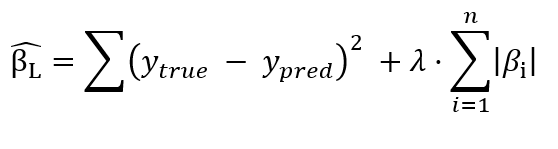

Instead of taking the square of each coefficient, Lasso regression takes the absolute values of them. The rest are practically the same. Let's see the regressor in action on a new dataset. I will load in the built-in diamonds dataset from Seaborn:

In [87]:
diamonds = sns.load_dataset('diamonds')
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Using all of the features, we will predict the price using Lasso:

In [88]:
X = pd.get_dummies(diamonds.drop('price', axis=1))
y = diamonds.price

Lasso and LassoCV is imported in the same way. We will find the best value of alpha using CV:

In [89]:
from sklearn.linear_model import Lasso, LassoCV

lasso = LassoCV(alphas=np.arange(0.000000001, 1, 0.05), cv=10)
_ = lasso.fit(X, y)
print('Best alpha:', lasso.alpha_)

Best alpha: 1e-09


It looks like choosing a very low alpha is good enough. Let's now fit with that value and evaluate the performance:

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1121218)
lasso = Lasso(alpha=int(1e-09))
lasso.fit(X_train, y_train)
preds = lasso.predict(X_test)
print("Training score:", lasso.score(X_train, y_train))
print("Testing score:", lasso.score(X_test, y_test))
print("MAE of Lasso Regression:", mean_absolute_error(y_test, preds), '\n')

Training score: 0.9200611187327303
Testing score: 0.9190684668165137
MAE of Lasso Regression: 742.5549731842253 



Lasso regression did a fairly good job. One really cool thing about Lasso regression is that it can be used for feature selection. Because of how it works under the hood, Lasso regression has the ability to shrink unimportant parameters all the way down to zero. We can check this by plotting the above fitted `lasso`'s coefficients using its `coef_` attribute:

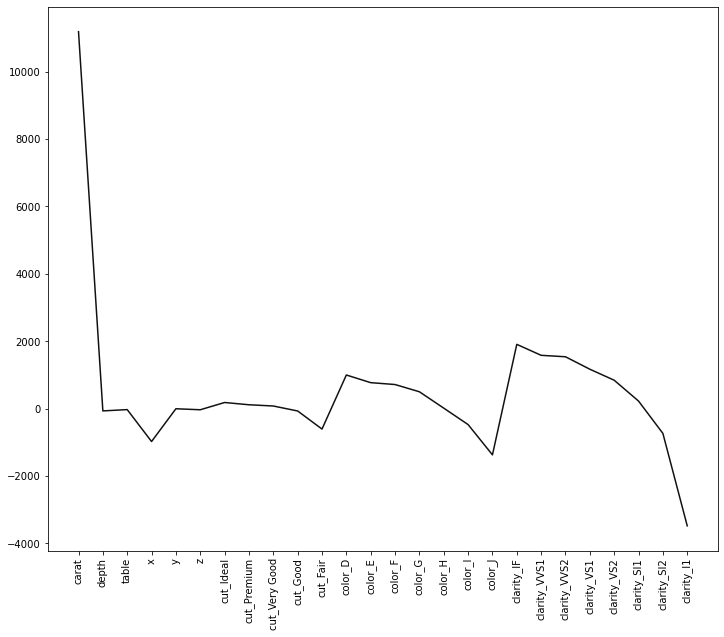

In [95]:
fig, ax = plt.subplots(figsize=(12, 10))

ax.plot(X_train.columns, lasso.coef_, color='#111111')

plt.setp(ax.get_xticklabels(), rotation=90);

As you can see, except for carat which seems to be the deciding factor for diamond price, all other coefficients are shrunk to close to 0:

In [98]:
print("Number of features before Lasso:", len(lasso.coef_))

Number of features before Lasso: 26


In [99]:
print("Number of features after fitting Lasso:", len(lasso.coef_[lasso.coef_ > 0]))

Number of features after fitting Lasso: 15


That is the main difference between Ridge and Lasso. Lasso shrinks unimportant features to 0 and only fits on important variables.